#  1.- Chilton f0F2 time series cleansing
## June 2022
### Dr Jose M Albornoz

In this notebook we will perform data cleansing aimed at dealing with imperfections (such as missing or malformed timestamps) in the hourly time series data for f0f2.

# Import necessary modules

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib import style
from matplotlib import cm
style.use('fivethirtyeight')
%matplotlib inline

from sklearn.metrics import r2_score

import random
import time

RANDOM_STATE = 801
pd.options.mode.chained_assignment = None

# maximum number of rdataframe ows and columns displayed
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 500)

# 1.- Load data

In [2]:
df_0 = pd.read_csv("Data/Chiltonf0f2_Clean_v1.csv", index_col=False)

In [3]:
df_0.shape

(102101, 2)

In [4]:
df_0.describe()

,f0f2
count,98783.000000
mean,5.497094
std,2.286629
min,0.900000
25%,3.700000
50%,5.200000
75%,6.700000
max,16.000000


In [5]:
df_0['Timestamp'] = pd.to_datetime(df_0['Timestamp'])

In [6]:
df_0['Timestamp'].min()

Timestamp('1995-03-20 15:00:00')

In [7]:
df_0['Timestamp'].max()

Timestamp('2009-03-31 18:00:00')

In [8]:
df_0.dtypes

Timestamp    datetime64[ns]
f0f2                float64
dtype: object

In [9]:
df_0.set_index('Timestamp', inplace=True) 

In [10]:
df_0.shape

(102101, 1)

In [11]:
df_0.head()

,f0f2
Timestamp,
1995-03-20 15:00:00,NaN
1995-03-20 16:00:00,5.7
1995-03-20 17:00:00,5.7
1995-03-20 18:00:00,5.3
1995-03-20 19:00:00,4.8


# 2.- Malformed timestamps

Since we have hourly data, the minutes fraction of correctly formed timestamps should be zero, as seen in the output of the above code cell. We will take advantage of this information to identify malformed timestamps.

In [12]:
# a series containing the minutes fraction of the f0f2 timestamps
timestamp_minutes = pd.Series(df_0.index.minute)

<AxesSubplot:>

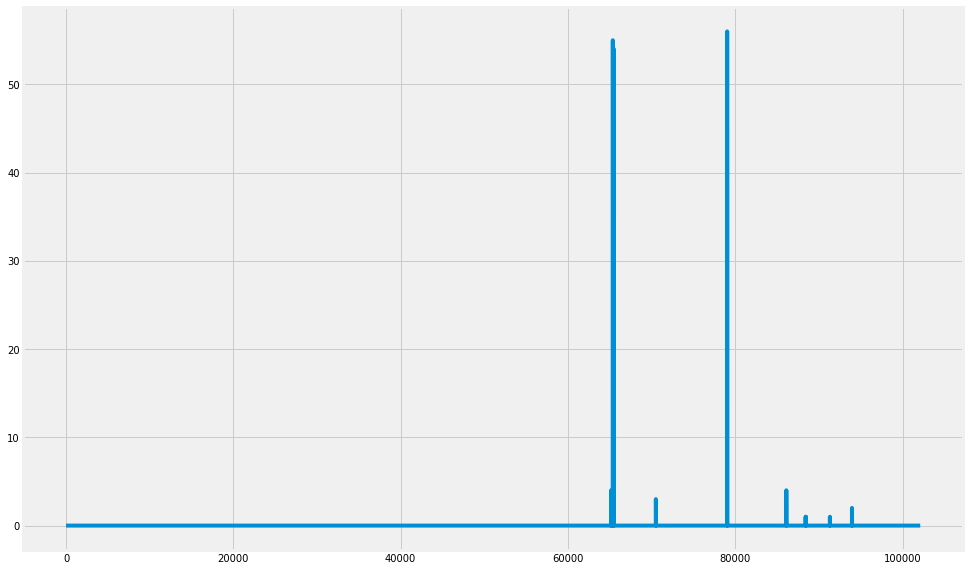

In [13]:
# we plot the series created above. correctly formed timestamps should have a zero minutes fraction
plt.figure(figsize=(15,10))
timestamp_minutes.plot()

As seen above, there are a few malformed timestamps (those whose minutes fraction is different from zero).

## 2.1.- List malformed timestamps

In [14]:
df_1 = df_0.copy()

In [15]:
df_1.reset_index(inplace=True)

In [16]:
df_1['mins'] = timestamp_minutes

In [17]:
df_1.head()

,Timestamp,f0f2,mins
0,1995-03-20 15:00:00,NaN,0
1,1995-03-20 16:00:00,5.7,0
2,1995-03-20 17:00:00,5.7,0
3,1995-03-20 18:00:00,5.3,0
4,1995-03-20 19:00:00,4.8,0


In [18]:
df_1["Malformed"] = df_1['mins'] != 0

In [19]:
df_malformed = df_1[df_1["Malformed"]]

In [20]:
df_malformed.head(30)

,Timestamp,f0f2,mins,Malformed
65153,2002-10-20 11:04:58,11.4,4,True
65288,2002-10-26 01:04:59,3.5,4,True
65357,2002-10-28 21:55:00,3.5,55,True
65486,2002-11-03 06:54:00,3.5,54,True
70503,2003-06-02 09:03:12,4.1,3,True
79025,2004-06-09 14:56:01,5.7,56,True
86095,2005-03-31 11:04:01,6.7,4,True
88416,2005-07-11 16:01:41,5.3,1,True
88431,2005-07-12 18:01:52,4.7,1,True
91306,2005-11-09 15:01:00,5.9,1,True


Let's have a closer look at these 11 malformed timestamps

In [21]:
for i in df_malformed.index:
    print(df_1.iloc[i-2:i+7,:].head(5))
    print("")

                Timestamp  f0f2  mins  Malformed
65151 2002-10-20 10:00:00  10.6     0      False
65152 2002-10-20 11:00:00  11.5     0      False
65153 2002-10-20 11:04:58  11.4     4       True
65154 2002-10-20 12:00:00  11.0     0      False
65155 2002-10-20 13:00:00  10.9     0      False

                Timestamp  f0f2  mins  Malformed
65286 2002-10-26 00:00:00   3.9     0      False
65287 2002-10-26 01:00:00   3.6     0      False
65288 2002-10-26 01:04:59   3.5     4       True
65289 2002-10-26 02:00:00   3.7     0      False
65290 2002-10-26 03:00:00   3.5     0      False

                Timestamp  f0f2  mins  Malformed
65355 2002-10-28 20:00:00   4.1     0      False
65356 2002-10-28 21:00:00   3.6     0      False
65357 2002-10-28 21:55:00   3.5    55       True
65358 2002-10-28 23:00:00   3.6     0      False
65359 2002-10-29 00:00:00   3.5     0      False

                Timestamp  f0f2  mins  Malformed
65484 2002-11-03 05:00:00   2.1     0      False
65485 2002-11-03 

We see that the malformed timestamps correspond to a) measurements that were made shortly after the hour; some of these constitute repeated measurements. b) measurements that were performed a few minutes before the hour. 

## 2.2.- Correct malformed timestamps

In order to correct malformed timestamps we will round them to the nearest hour: that is, 
- if the minutes value is less than 10 minutes, both minutes and seconds values will be set to zero - effectively rounding down the timestamp to the previous hour.
- if the minutes value is greater than 50 minutes, both minutes and seconds values will be set to zero, and the hour fraction will increased by 1. We are rounding up the timestamp to the next hour.

This above logic is implemented by the function in the following cell.

In [22]:
# A function to deal with malformed timestamps
def correct_malformed_timestamps(timestamp):
    if timestamp.minute < 10:
        timestamp = timestamp.replace(minute=0, second=0)
    elif timestamp.minute > 50:
        timestamp = timestamp.replace(hour = timestamp.hour + 1, minute=0, second=0)
    return timestamp    

In [23]:
df_2 = df_1.copy()

In [24]:
df_2['Timestamp'] = df_2['Timestamp'].apply(lambda x:correct_malformed_timestamps(x))

In [25]:
df_2.drop(['mins', 'Malformed'], axis=1, inplace=True)

In [26]:
df_2.head()

,Timestamp,f0f2
0,1995-03-20 15:00:00,NaN
1,1995-03-20 16:00:00,5.7
2,1995-03-20 17:00:00,5.7
3,1995-03-20 18:00:00,5.3
4,1995-03-20 19:00:00,4.8


We will now verify that there are no malformed timestamps anymore by examining minutes values.

<AxesSubplot:>

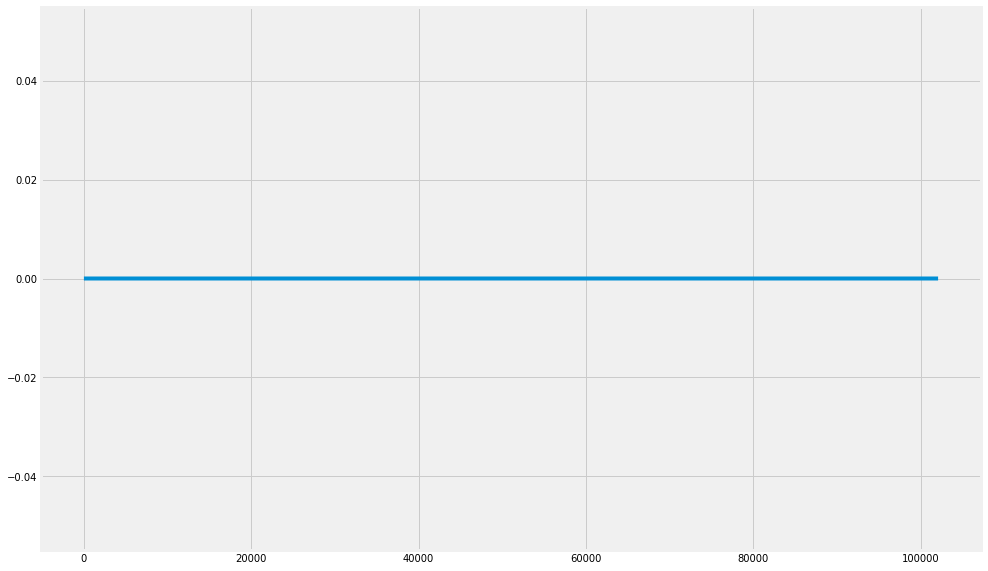

In [27]:
timestamp_minutes = df_2.Timestamp.apply(lambda x:x.minute)
plt.figure(figsize=(15,10))
timestamp_minutes.plot()

## 2.3.- Drop duplicate timestamps

As a result of the correction of malformed timestamps some duplication will arise; we correct this duplication in the following cells.

In [28]:
duplicated_rows = df_2['Timestamp'].duplicated()

In [29]:
duplicated_rows.sum()

3

In [30]:
df_3 = df_2[~duplicated_rows]

In [31]:
df_3.set_index("Timestamp", inplace=True)

In [32]:
df_3.shape

(102098, 1)

# 3.- Dealing with missing timestamps

## 3.1.- Identify missing timestamps

In [33]:
df_3.sort_index(inplace=True)

In [34]:
df_3.head()

,f0f2
Timestamp,
1995-03-20 15:00:00,NaN
1995-03-20 16:00:00,5.7
1995-03-20 17:00:00,5.7
1995-03-20 18:00:00,5.3
1995-03-20 19:00:00,4.8


In the following cell we will visually identify gaps in the time series by computing the difference in hours between successive timestamps

<AxesSubplot:>

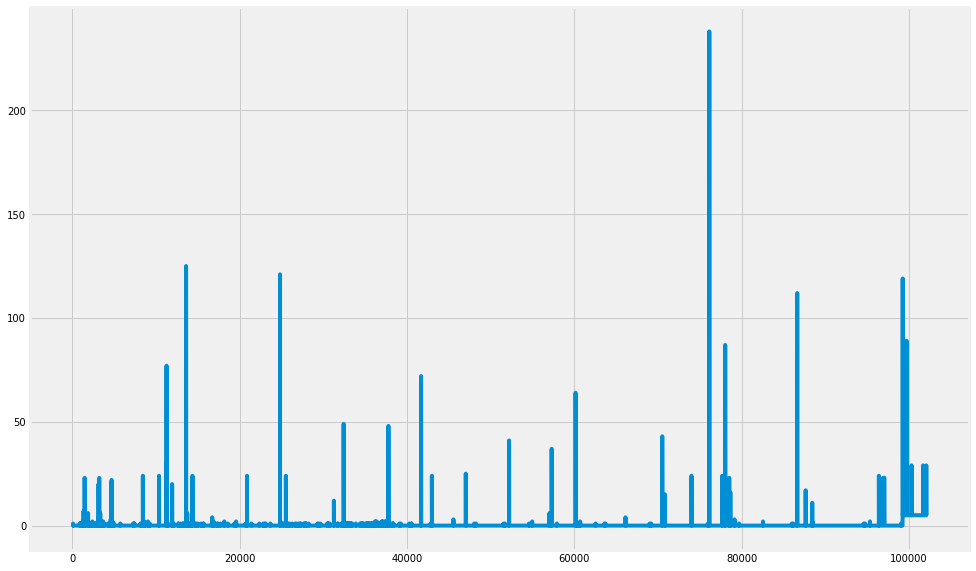

In [35]:
timestamp_gaps = pd.Series(df_3.index).diff()/np.timedelta64(1, 'h') - 1

plt.figure(figsize=(15,10))
timestamp_gaps.plot()

As seen in the above plot, there are quite a few missing timestamps in our dataset.

In [36]:
df_timestamp_gaps = timestamp_gaps.to_frame() 

In [37]:
df_timestamp_gaps[df_timestamp_gaps.Timestamp != 0].head(500)

,Timestamp
0,NaN
73,1.0
880,1.0
915,1.0
960,1.0
1134,1.0
1334,7.0
1349,1.0
1352,1.0
1354,3.0


In [38]:
df_timestamp_gaps[df_timestamp_gaps.Timestamp != 0].sum()

Timestamp    20906.0
dtype: float64

There are 20906 missing timestamps in our dataset

## 3.2.- Insert missing timestamps

In [39]:
df_4 = df_3.reindex(pd.date_range(start=df_3.index[0], end=df_3.index[-1], freq='1h'))

Let's verify that the missing timestamps were inserted:

<AxesSubplot:>

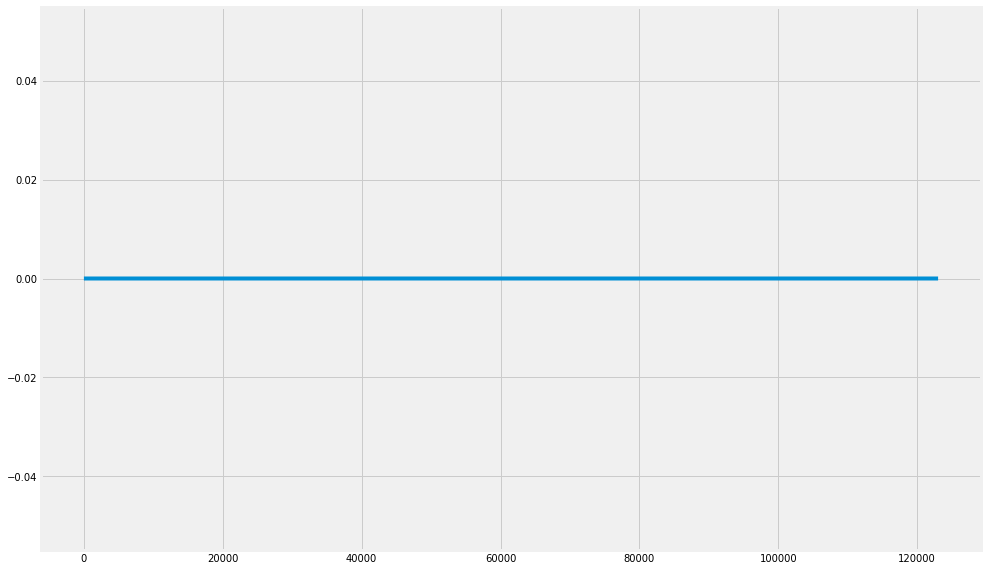

In [40]:
timestamp_gaps = pd.Series(df_4.index).diff()/np.timedelta64(3600, 's') - 1
plt.figure(figsize=(15,10))
timestamp_gaps.plot()

In [41]:
df_4.shape[0] - df_3.shape[0]

20906

Sanity check: the above number matches the number of missing timestamps found before. 

In [42]:
(df_4.shape[0] - df_3.shape[0])*100/df_4.shape[0]

16.99619524568307

We have almost 17% missing timestamps.

In [43]:
df_4.isna().sum()

f0f2    24224
dtype: int64

In [44]:
df_4.isna().sum()*100/df_4.shape[0]

f0f2    19.693668
dtype: float64

The resulting time series has 19.7% missing values

## 3.3.-  Plot series

Text(0.5, 1.0, 'Chilton f0F2 time series')

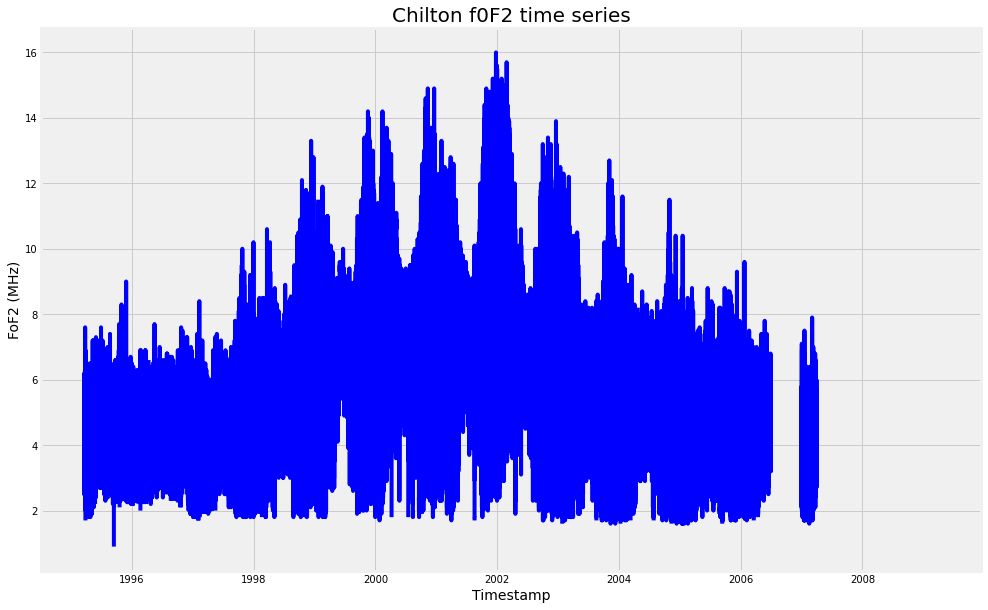

In [45]:
plt.figure(figsize=(15,10))
plt.plot(df_4.index, df_4['f0f2'], color='blue')

plt.xlabel('Timestamp', fontsize=14)
plt.ylabel('FoF2 (MHz)', fontsize=14)
plt.title('Chilton f0F2 time series', fontsize=20)

As seen above, there is a large chunk of missing data between 2006 and 2008; perhaps it will make sense to re-define the period of time covered by our series

In [46]:
df_5 = df_4[(df_4.index > '2006-06-30 12:00:00') & (df_4.index < '2007-05-01 00:00:00')]

Text(0.5, 1.0, 'Chilton f0F2 time series')

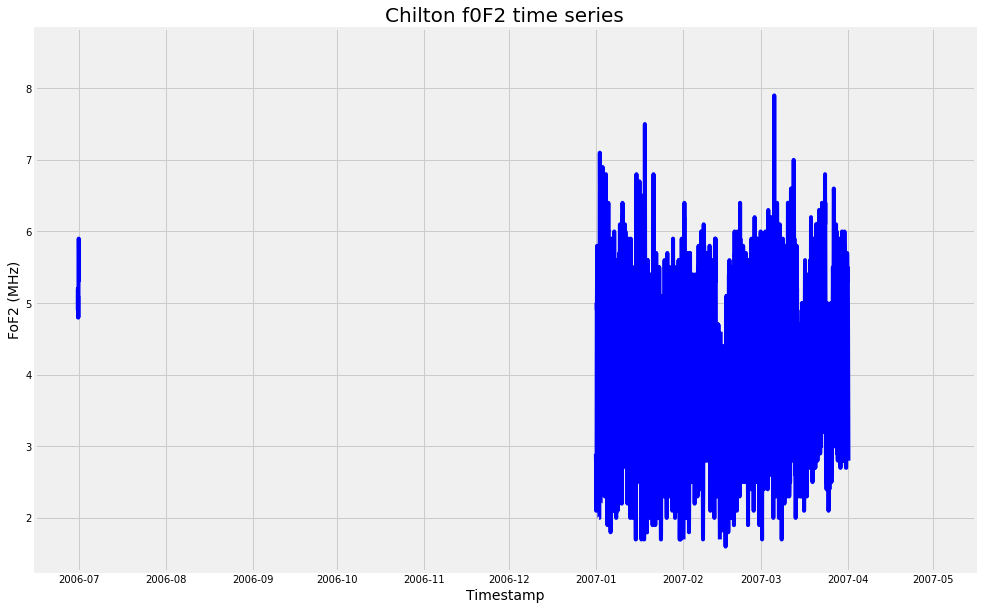

In [47]:
plt.figure(figsize=(15,10))
plt.plot(df_5.index, df_5['f0f2'], color='blue')

plt.xlabel('Timestamp', fontsize=14)
plt.ylabel('FoF2 (MHz)', fontsize=14)
plt.title('Chilton f0F2 time series', fontsize=20)

There is a large gap in the series after '2006-06-30 23:00:00'; for this reason we will consider a new period of time for the series that runs up to this timestamp

In [48]:
df_5 = df_4[(df_4.index <= '2006-06-30 23:00:00')]

Text(0.5, 1.0, 'Chilton f0F2 time series')

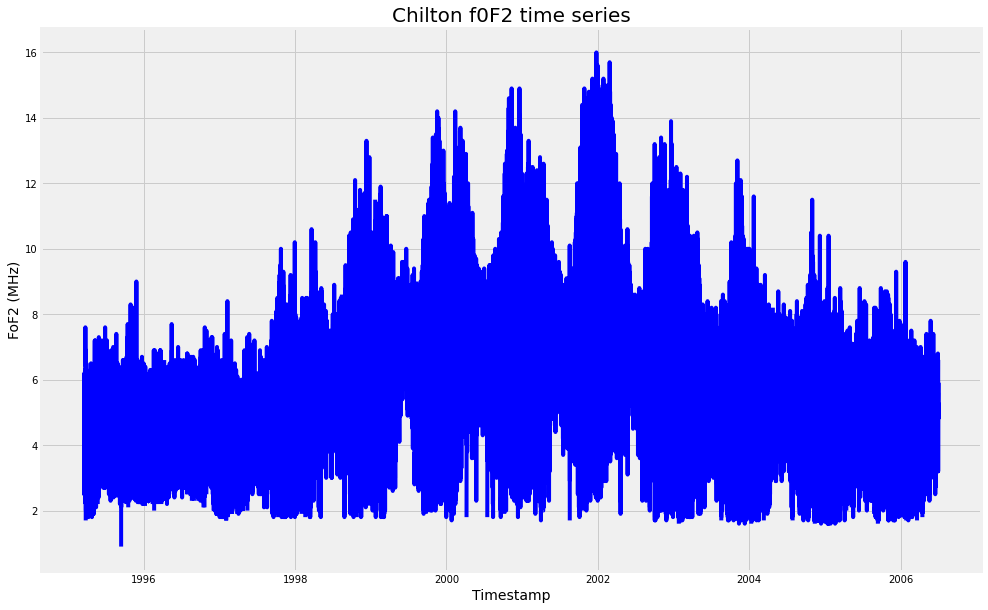

In [49]:
plt.figure(figsize=(15,10))
plt.plot(df_5.index, df_5['f0f2'], color='blue')

plt.xlabel('Timestamp', fontsize=14)
plt.ylabel('FoF2 (MHz)', fontsize=14)
plt.title('Chilton f0F2 time series', fontsize=20)

In [50]:
df_5.shape

(98889, 1)

In [51]:
df_5.isna().sum()

f0f2    5192
dtype: int64

In [52]:
df_5.isna().sum()*100/df_5.shape[0]

f0f2    5.250331
dtype: float64

The percentage of missing values in the reduced series is now 5.25%

# 4.-  Write cleansed and imputed series to disk

In [53]:
df_5.describe()

,f0f2
count,93697.000000
mean,5.580767
std,2.301045
min,0.900000
25%,3.800000
50%,5.300000
75%,6.800000
max,16.000000


In [54]:
df_5.shape

(98889, 1)

In [55]:
df_5.head()

,f0f2
1995-03-20 15:00:00,NaN
1995-03-20 16:00:00,5.7
1995-03-20 17:00:00,5.7
1995-03-20 18:00:00,5.3
1995-03-20 19:00:00,4.8


In [56]:
df_5.tail()

,f0f2
2006-06-30 19:00:00,5.1
2006-06-30 20:00:00,5.4
2006-06-30 21:00:00,5.9
2006-06-30 22:00:00,5.7
2006-06-30 23:00:00,5.3


In [57]:
df_5.reset_index(inplace=True)

In [58]:
df_5.head()

,index,f0f2
0,1995-03-20 15:00:00,NaN
1,1995-03-20 16:00:00,5.7
2,1995-03-20 17:00:00,5.7
3,1995-03-20 18:00:00,5.3
4,1995-03-20 19:00:00,4.8


In [59]:
df_5.rename(columns={'index': 'Timestamp'}, inplace=True)

In [60]:
df_5.head()

,Timestamp,f0f2
0,1995-03-20 15:00:00,NaN
1,1995-03-20 16:00:00,5.7
2,1995-03-20 17:00:00,5.7
3,1995-03-20 18:00:00,5.3
4,1995-03-20 19:00:00,4.8


In [61]:
df_5.to_csv("Data/Chiltonf0f2_Clean_v2_no_imputation.csv", index=False)